# 피마 인디언 당뇨병 데이터

- 데이터 활용 목적 : 당뇨병 여부를 판단하는 머신러닝 예측 모델을 개발
- 데이터 개요
    - 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터
    - 일반적으로 알려진 당뇨병의 원인은 식습관과 유전
        - 피마 지역은 고립된 지역에서 인디언 고유의 혈통이 지속됨
        - 20세기 후반 서구화된 식습관으로 많은 당뇨 환자가 발생
        
    - 피처
        - Pregnancies : 임신 횟수
        - Glucose : 포도당 부하 검사 수치
        - BloodPressure : 혈압(mm Hg)
        - SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
        - Insulin : 혈청 인슐린(mm U/ml)
        - BMI : 체질량 지수(체중(kg) / 키(m))^2
        - DiabetesPedigreeFuction : 당뇨 내력 가중치 값
        - Age : 나이
        - Outcome : 클래스 결정 값(0 또는 1)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score, f1_score,
                             confusion_matrix, precision_recall_curve, roc_curve)
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("./data/diabetes.csv")

In [8]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [10]:
df.shape

(768, 9)

In [11]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- 결측치는 없고 피처의 타입은 모두 숫자형

In [13]:
# 평가지표 출력하는 함수 _ StandardScale
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")

In [14]:
def precision_recall_curve_plot(y_test = None, pred_proba_c1 = None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 시각화 수행
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:threshold_boundary], linestyle = "--", label = "precision")
    plt.plot(thresholds, recalls[:threshold_boundary], label = "recall")
    
    # threshold 값 x축의 단위를 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, grid 설정
    plt.xlabel("Threshold value")
    plt.ylabel("Precision & Recall value")
    plt.legend()
    plt.grid()
    plt.show()

# baseline 모델

In [16]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 11, stratify = y)

In [19]:
x_train.shape, x_test.shape

((614, 8), (154, 8))

In [21]:
# baseline 로지스틱 회귀
lr_clf1 = LogisticRegression(random_state = 11)
lr_clf1.fit(x_train, y_train)
pred1 = lr_clf1.predict(x_test)
pred_proba1 = lr_clf1.predict_proba(x_test)[:, 1]

In [22]:
get_clf_eval(y_test, pred1, pred_proba1)

오차 행렬
[[89 11]
 [24 30]]
정확도: 0.7727, 정밀도: 0.7317, 재현율: 0.5556, F1: 0.6316, AUC: 0.8461


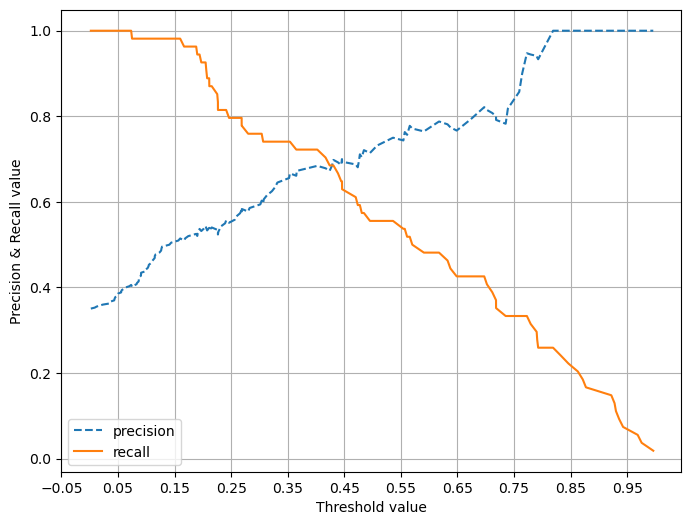

In [23]:
pred_proba_c1 = lr_clf1.predict_proba(x_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

- 임곗값이 대략 0.44 정도에서 정밀도와 재현율이 균형을 맞출 것으로 보임
- 점수를 더 높이기 위해 데이터 전처리 수행

# 데이터 전처리

In [24]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- 데이터 값의 최솟값이 0인 피처가 존재
    - 포도당, 혈압, 피하지방, 인슐린, BMI가 0인 것은 납득하기 어려움

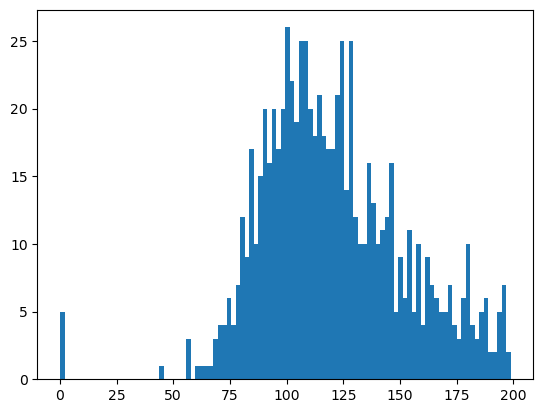

In [26]:
plt.hist(df["Glucose"], bins = 100)
plt.show()

- 포도당이 0인 데이터가 5개 존재

In [27]:
# 0값을 검사할 피처명 리스트
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [29]:
# 전체 데이터 건수
total_count = df["Glucose"].count()

In [31]:
# 피처별로 반복하면서 데이터 값이 0인 데이터 건수 추출하고, 비율 계산
for feature in zero_features:
    zero_count = df[df[feature] == 0][feature].count()
    print(f"{feature} 0 건수는 {zero_count}, 비율은 {100 * zero_count / total_count:.2f}")

Glucose 0 건수는 5, 비율은 0.65
BloodPressure 0 건수는 35, 비율은 4.56
SkinThickness 0 건수는 227, 비율은 29.56
Insulin 0 건수는 374, 비율은 48.70
BMI 0 건수는 11, 비율은 1.43


- SkinThickness와 Insulin 의 0 값 비율이 꽤 높은 편이어서 데이터 일괄 삭제 시 오히려 학습에 악영향을 줄 수 있음
    - 이상치를 평균값으로 대체

In [32]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균값으로 대체
mean_zero_features = df[zero_features].mean()
mean_zero_features

Glucose          120.894531
BloodPressure     69.105469
SkinThickness     20.536458
Insulin           79.799479
BMI               31.992578
dtype: float64

In [33]:
df[zero_features] = df[zero_features].replace(0, mean_zero_features)

In [34]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# 모델 학습 테스트

In [35]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [36]:
x_train, x_test, y_train, y_te
st = train_test_split(x, y, test_size = 0.2, random_state = 11, stratify = y)

In [37]:
# StandardScaler 를 통해 스케일링 적용
scaler = StandardScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [38]:
# 로지스틱 회귀 학습, 예측, 평가
lr_clf2 = LogisticRegression(random_state = 11)
lr_clf2.fit(scaled_train, y_train)
pred2 = lr_clf2.predict(scaled_test)
pred_proba2 = lr_clf2.predict_proba(scaled_test)[:, 1]

In [39]:
get_clf_eval(y_test, pred2, pred_proba2)

오차 행렬
[[88 12]
 [25 29]]
정확도: 0.7597, 정밀도: 0.7073, 재현율: 0.5370, F1: 0.6105, AUC: 0.8461


In [40]:
logi = LogisticRegression(random_state = 11)

param = {"penalty" : ["l1", "l2", "elasticnet", None],
        "C" : [0.01, 0.1, 1, 10, 100],
        "solver" : ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]}

splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 11)

gs = GridSearchCV(logi, param, scoring = "roc_auc", cv = splitter, n_jobs = -1)
gs.fit(scaled_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
             estimator=LogisticRegression(random_state=11), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc')

In [41]:
gs.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [42]:
lr_clf3 = gs.best_estimator_

In [45]:
pred3 = lr_clf3.predict(scaled_test)
pred_proba3 = lr_clf3.predict_proba(scaled_test)[:, 1]

In [46]:
get_clf_eval(y_test, pred3, pred_proba3)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741, F1: 0.6392, AUC: 0.8400


# 모델 성능 평가

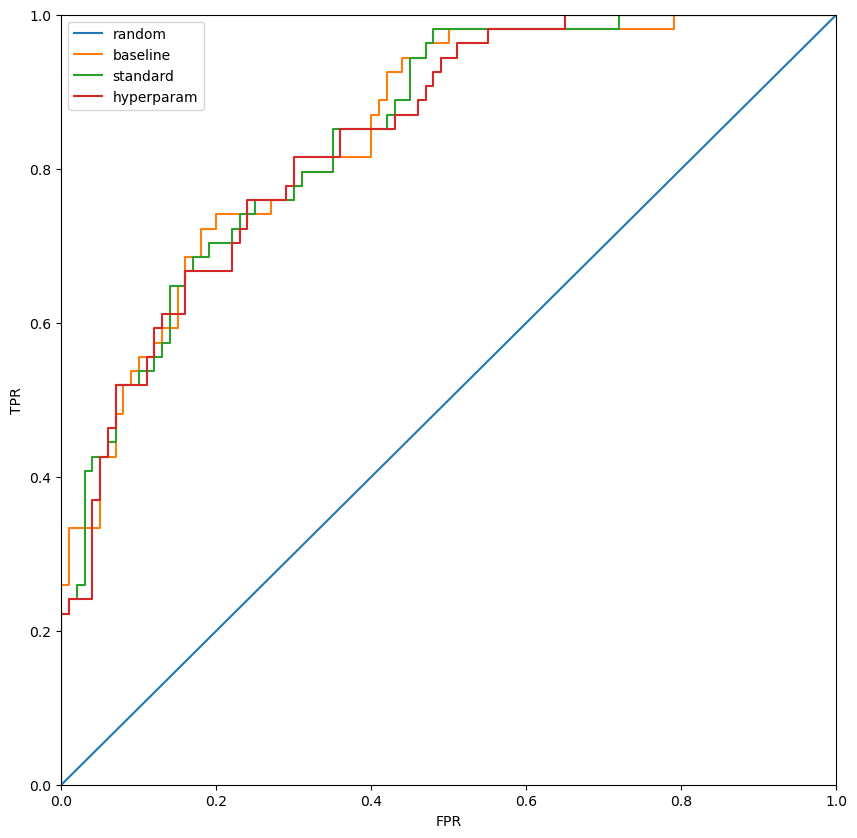

In [47]:
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_proba1)
fpr2, tpr2, threshold2 = roc_curve(y_test, pred_proba2)
fpr3, tpr3, threshold3 = roc_curve(y_test, pred_proba3)

plt.figure(figsize = (10, 10))

plt.plot([0, 1], [0, 1], label = "random")
plt.plot(fpr1, tpr1, label = "baseline")
plt.plot(fpr2, tpr2, label = "standard")
plt.plot(fpr3, tpr3, label = "hyperparam")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [48]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds 리스트 내의 값을 차례로 반복하면서 검증
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold)
        binarizer.fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임겟값:", custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
        print("-" * 80)

In [50]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.5]

In [51]:
get_eval_by_threshold(y_test, pred_proba1.reshape(-1, 1), thresholds)

임겟값: 0.3
오차 행렬
[[72 28]
 [13 41]]
정확도: 0.7338, 정밀도: 0.5942, 재현율: 0.7593, F1: 0.6667, AUC: 0.8461
--------------------------------------------------------------------------------
임겟값: 0.33
오차 행렬
[[78 22]
 [14 40]]
정확도: 0.7662, 정밀도: 0.6452, 재현율: 0.7407, F1: 0.6897, AUC: 0.8461
--------------------------------------------------------------------------------
임겟값: 0.36
오차 행렬
[[80 20]
 [15 39]]
정확도: 0.7727, 정밀도: 0.6610, 재현율: 0.7222, F1: 0.6903, AUC: 0.8461
--------------------------------------------------------------------------------
임겟값: 0.39
오차 행렬
[[82 18]
 [15 39]]
정확도: 0.7857, 정밀도: 0.6842, 재현율: 0.7222, F1: 0.7027, AUC: 0.8461
--------------------------------------------------------------------------------
임겟값: 0.42
오차 행렬
[[82 18]
 [17 37]]
정확도: 0.7727, 정밀도: 0.6727, 재현율: 0.6852, F1: 0.6789, AUC: 0.8461
--------------------------------------------------------------------------------
임겟값: 0.45
오차 행렬
[[85 15]
 [21 33]]
정확도: 0.7662, 정밀도: 0.6875, 재현율: 0.6111, F1: 0.6471, AUC: 0.8461
--------

In [54]:
# 임곗값을 0.39로 설정한 Binarizer 생성
binarizer = Binarizer(threshold = 0.39)
pred_th = binarizer.fit_transform(pred_proba1.reshape(-1, 1))

In [56]:
get_clf_eval(y_test, pred_th, pred_proba1)

오차 행렬
[[82 18]
 [15 39]]
정확도: 0.7857, 정밀도: 0.6842, 재현율: 0.7222, F1: 0.7027, AUC: 0.8461
